In this benchmark, we try to achieve the highest throughput (MB/s) while reading a single ROOT file.

In [1]:
import os, sys
sys.path.append(os.getcwd()+"/../")
import copy
import yaml
from src.utils import recreate_dir
from src.benchmark import Benchmark, run_benchmark

In [2]:
default_config = {
    'data-access': {
        'mode': 'explicit-files',
        'files': []
    },
    'executor': {
        'backend': 'sequential',
        'n_workers': 1
    },
    'processor': {
        'parallelize_over': 'files',
        'columns': {},
        'load_columns_into_memory': True,
        'worker_operation_time': 0
    }
}

In [3]:
file_name = "90322FC2-4027-0E47-92E4-22307EC8EAD2.root"
file_locations = {
    "depot": "/depot/cms/users/dkondra/",
    "work": "/work/projects/purdue-af/",
    "eos_fuse": "/eos/purdue/store/data/Run2016B/SingleMuon/NANOAOD/02Apr2020_ver2-v1/20000/",
    "xrootd": "root://eos.cms.rcac.purdue.edu:1094//store/data/Run2016B/SingleMuon/NANOAOD/02Apr2020_ver2-v1/20000/",
    "xcache": "root://cms-xcache.rcac.purdue.edu:1094//store/data/Run2016B/SingleMuon/NANOAOD/02Apr2020_ver2-v1/20000/"
}

column_presets = {
    "100pct": {
        # the bechmark will limit this to actual total number of columns
        "method": "n_columns",
        "values": 100000
    },
    "50pct": {
        "method": "collections",
        "values": ["Jet", "Photon", "Tau", "Electron", "Muon"]
    },
    "10pct": {
        "method": "collections",
        "values": ["Muon"]
    },
    "5pct": {
        "method": "column_list",
        "values": [
            "run", "luminosityBlock", "HLT_IsoMu24", "PV_npvsGood", "fixedGridRhoFastjetAll",
            "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", "Muon_charge", "Muon_pfRelIso04_all", "Muon_mediumId", "Muon_ptErr",
            "Electron_pt", "Electron_eta", "Electron_mvaFall17V2Iso_WP90",
            "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
        ]
    }
}

In [4]:
def generate_configs(save_dir="./"):
    recreate_dir(save_dir)

    iconf = 0
    repeat = 5

    for f_label, file_loc in file_locations.items():
        for c_label, column_setup in column_presets.items():
            for irep in range(repeat):
                config = copy.deepcopy(default_config)
    
                config["data-access"]["files"] = [f"{file_loc}/{file_name}"]
                config["processor"]["columns"] = column_setup
    
                # Custom labels to save to output dataframe
                config["custom_labels"] = {
                    "file_location": f_label,
                    "column_setup": c_label
                }
    
                unique_label =  f"2p1_{f_label}_{c_label}_{irep}"
    
                config["unique_label"] = unique_label
                config_name = f'config_{unique_label}.yaml'
                
                with open(f'{save_dir}/{config_name}', 'w') as file:
                    yaml.dump(config, file, default_flow_style=False)
    
                iconf += 1

    print(f'Saved {iconf} config files to {save_dir}')

In [5]:
# warning: all YAML files will be deleted from config directory before proceeding
config_path = "./configs_2.1"
output_path = "./outputs_2.1"
generate_configs(config_path)

In [ ]:
report = run_benchmark(config_path, output_path)

Directory ./outputs_2.1 already exists, will clean all files from it.


  1%|          | 1/100 [00:19<31:37, 19.16s/it]

In [8]:
report.sort_values(by=['column_setup', 'file_location']).reset_index(drop=True)

,n_files,n_columns_read,n_events,loaded_columns,worker_operation_time,executor,n_workers,compressed_bytes,uncompressed_bytes,time:run_processor,time:wait,time:decompress,column_setup,file_location
0,1,1249,3854952319,True,0,sequential,1,2048077850,11568311796,246.806087,0.494070,166.181469,100pct,depot
1,1,1249,3854952319,True,0,sequential,1,2048077850,11568311796,242.890458,0.494278,162.216860,100pct,depot
2,1,1249,3854952319,True,0,sequential,1,2048077850,11568311796,242.882858,0.492016,162.148665,100pct,depot
3,1,1249,3854952319,True,0,sequential,1,2048077850,11568311796,242.313256,0.490587,161.856776,100pct,depot
4,1,1249,3854952319,True,0,sequential,1,2048077850,11568311796,243.378389,0.494578,162.048801,100pct,depot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,20,61728620,True,0,sequential,1,175488912,521753090,31.169582,13.705979,13.310637,5pct,xrootd
96,1,20,61728620,True,0,sequential,1,175488912,521753090,69.664148,52.051985,13.323399,5pct,xrootd
97,1,20,61728620,True,0,sequential,1,175488912,521753090,67.827847,50.425657,13.305850,5pct,xrootd
98,1,20,61728620,True,0,sequential,1,175488912,521753090,65.893562,48.255377,13.326851,5pct,xrootd


In [11]:
report.groupby(['column_setup', 'file_location']).agg('mean')

/tmp/ipykernel_186141/1348247025.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  report.groupby(['column_setup', 'file_location']).agg('mean')


n_files  n_columns_read      n_events  \
column_setup file_location                                          
100pct       depot              1.0          1249.0  3.854952e+09   
             eos_fuse           1.0          1249.0  3.854952e+09   
             work               1.0          1249.0  3.854952e+09   
             xcache             1.0          1249.0  3.854952e+09   
             xrootd             1.0          1249.0  3.854952e+09   
10pct        depot              1.0            50.0  1.543216e+08   
             eos_fuse           1.0            50.0  1.543216e+08   
             work               1.0            50.0  1.543216e+08   
             xcache             1.0            50.0  1.543216e+08   
             xrootd             1.0            50.0  1.543216e+08   
50pct        depot              1.0           233.0  7.191384e+08   
             eos_fuse           1.0           233.0  7.191384e+08   
             work               1.0           233.0  7.191384e+08   
             xcache             1.0           233.0  7.191384e+08   
             xrootd             1.0           233.0  7.191384e+08   
5pct         depot              1.0            20.0  6.172862e+07   
             eos_fuse           1.0            20.0  6.172862e+07   
             work               1.0            20.0  6.172862e+07   
             xcache             1.0            20.0  6.172862e+07   
             xrootd             1.0            20.0  6.172862e+07   

                            loaded_columns  worker_operation_time  n_workers  \
column_setup file_location                                                     
100pct       depot                     1.0                    0.0        1.0   
             eos_fuse                  1.0                    0.0        1.0   
             work                      1.0                    0.0        1.0   
             xcache                    1.0                    0.0        1.0   
             xrootd                    1.0                    0.0        1.0   
10pct        depot                     1.0                    0.0        1.0   
             eos_fuse                  1.0                    0.0        1.0   
             work                      1.0                    0.0        1.0   
             xcache                    1.0                    0.0        1.0   
             xrootd                    1.0                    0.0        1.0   
50pct        depot                     1.0                    0.0        1.0   
             eos_fuse                  1.0                    0.0        1.0   
             work                      1.0                    0.0        1.0   
             xcache                    1.0                    0.0        1.0   
             xrootd                    1.0                    0.0        1.0   
5pct         depot                     1.0                    0.0        1.0   
             eos_fuse                  1.0                    0.0        1.0   
             work                      1.0                    0.0        1.0   
             xcache                    1.0                    0.0        1.0   
             xrootd                    1.0                    0.0        1.0   

                            compressed_bytes  uncompressed_bytes  \
column_setup file_location                                         
100pct       depot              2.048078e+09        1.156831e+10   
             eos_fuse           2.048078e+09        1.156831e+10   
             work               2.048078e+09        1.156831e+10   
             xcache             2.048078e+09        1.156831e+10   
             xrootd             2.048078e+09        1.156831e+10   
10pct        depot              2.655942e+08        1.129031e+09   
             eos_fuse           2.655942e+08        1.129031e+09   
             work               2.655942e+08        1.129031e+09   
             xcache             2.655942e+08        1.129031e+09   


In [30]:
report["column_setup"] = report["column_setup"].apply(lambda x: x.replace('pct', '% of data'))

measurements = ["time:run_processor", "time:decompress", "time:wait"]
other_cols = [c for c in report.columns if c not in measurements]

agg = {}
for c in report.columns:
    if c in measurements:
        agg[c] = ['mean', 'std']

aggregated = report.groupby(other_cols).agg(agg)

aggregated_reset = aggregated.reset_index()
    

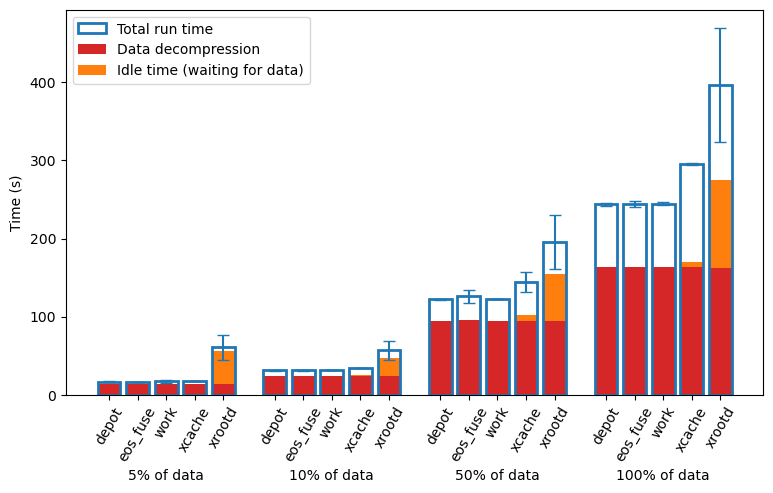

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9,5))

# Heights of the bars
decompress = aggregated_reset[('time:decompress', 'mean')]
wait = aggregated_reset[('time:wait', 'mean')]
run_processor = aggregated_reset[('time:run_processor', 'mean')]

# Error bars
run_processor_err = aggregated_reset[('time:run_processor', 'std')]

# Positions for bars
x = aggregated_reset[['file_location', 'column_setup']].reset_index(drop=True)

bar_width = 1

# Arrange bars in groups by column setup
group_pos = 0
step = 1.25
group_gap = 1
mult = group_mult = 0

for col in x.column_setup.unique():
    for fl in x.file_location.unique():
        loc = (x.column_setup==col) & (x.file_location==fl)
        x.loc[loc, "position"] = group_pos + step * mult
        mult += 1
    group_pos += group_gap
    

# Plot the stacked bars
p1 = ax.bar(x.position, decompress, bar_width,label='time:decompress', color='tab:red', )
p2 = ax.bar(x.position, wait, bar_width, bottom=decompress, label='time:wait', color='tab:orange', )
p3 = ax.bar(x.position, run_processor, bar_width, yerr=run_processor_err, label='time:run_processor', 
            facecolor='none', linewidth=2, edgecolor='tab:blue', ecolor='tab:blue', capsize=4)

ax.set_xticks(x.position, x.file_location)
ax.set_ylabel('Time (s)')
# ax.set_ylim(0,110)
ax.set_title('')
# ax.legend()
ax.legend(handles=[p3, p1, p2], labels=['Total run time', 'Data decompression', 'Idle time (waiting for data)'])
plt.xticks(rotation=60)

ax2 = ax.secondary_xaxis('bottom')
ax2_labels = x.groupby("column_setup").mean(numeric_only=True).reset_index()
ax2.set_xticks(ax2_labels.position, ax2_labels.column_setup)
ax2.spines['bottom'].set_position(('outward', 50))
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(which='both', length=0)


plt.show()
fig.savefig(f"{output_path}/plot.pdf", bbox_inches='tight')